In [1]:
from IPython.display import Image
import collections
import csv,re,sys,os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io import wb
import locale
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
locale.setlocale(locale.LC_ALL, 'en_US.utf8')

def replaceThousands(n):
    '''Format large numbers'''
    return locale.format("%d",n, grouping=True)

In [3]:
sns.set_context('paper')

In [4]:
def setFigSize(dim=(16.5,5.5)):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(dim[0],dim[1])

###Grab CAIDA AS Data

In [5]:
if not os.path.exists('../data'):
    os.mkdir('../data')

if not os.path.exists('../data/midar-iff.nodes.geo'):
    !wget http://data.caida.org/datasets/topology/ark/ipv4/itdk/2013-04/kapar-midar-iff.nodes.geo.gz && \
        gunzip ../data/midar-iff.nodes.geo.gz


In [13]:
if False:
    !grep -v '#' midar-iff.nodes.geo | awk -F '\t' '{print $1"\t"$3}' > midar-iff.nodes.geo_reduced


###Read in Geolocated AS Data

In [6]:
df=pd.read_csv('../data/midar-iff.nodes.geo_reduced',quotechar='#',delimiter='\t',header=False,names=['id','country'])

In [7]:
df.shape

(31788985, 2)

###Get Country Names and ISO Codes

In [41]:
iso=wb.get_countries()
# 'name','iso2c'
iso.incomeLevel=iso.incomeLevel.apply(lambda x: re.sub(r'High income: nonOECD|High income: OECD','High income',x))
# Collpase OECD and non OECD high income countries

###Get Populations

In [14]:
popDf=wb.download(indicator='SP.POP.TOTL',start=2013,end=2013,country=[v for v in iso.iso2c.values if v])

popDf.index=popDf.index.reorder_levels([1,0])

In [15]:
popDf=popDf.unstack(level=0)
#popDf['iso']=[v for v in iso.iso2c.values if v]

In [ ]:
'''popVals=[]
countries=[]
for row in popDf.iterrows():
#    print row[0][1]
#    print row[1]['SP.POP.TOTL']
    popVals.append(row[1]['SP.POP.TOTL'])
    countries.append(row[0][1])
popDf=pd.DataFrame(data={'pop':popVals},index=countries)
'''

In [16]:
popDf.head()

,SP.POP.TOTL
year,2013
country,
Afghanistan,30551674
Albania,2897366
Algeria,39208194
American Samoa,55165
Andorra,79218


In [42]:
iso.index=iso.name

In [43]:
iso=iso.join(popDf)

In [46]:
iso=iso[~(iso.incomeLevel=="Aggregates")]

In [47]:
iso.head()

,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,"(SP.POP.TOTL, 2013)"
name,,,,,,,,,,,
Aruba,,Oranjestad,ABW,High income,AW,12.5167,Not classified,-70.0167,Aruba,Latin America & Caribbean (all income levels),102911
Afghanistan,South Asia,Kabul,AFG,Low income,AF,34.5228,IDA,69.1761,Afghanistan,South Asia,30551674
Angola,Sub-Saharan Africa (developing only),Luanda,AGO,Upper middle income,AO,-8.81155,IBRD,13.242,Angola,Sub-Saharan Africa (all income levels),21471618
Albania,Europe & Central Asia (developing only),Tirane,ALB,Upper middle income,AL,41.3317,IBRD,19.8172,Albania,Europe & Central Asia (all income levels),2897366
Andorra,,Andorra la Vella,AND,High income,AD,42.5075,Not classified,1.5218,Andorra,Europe & Central Asia (all income levels),79218


In [48]:
iso.incomeLevel.value_counts()

High income            80
Upper middle income    53
Lower middle income    51
Low income             31
dtype: int64

In [49]:
isoHash={}

for r in iso.iterrows():
#    print r[1][4],r[1][8]
    isoHash[r[1][4]]=r[1][8]

In [50]:
df.head()

,id,country
0,node.geo N2:,SG
1,node.geo N3:,SG
2,node.geo N4:,SG
3,node.geo N5:,IL
4,node.geo N6:,FR


In [51]:
%%time
replaceRe=re.compile(r'node.geo|:')
df['idClean']=df.id.apply(lambda x:re.sub(replaceRe,'',x))
#df['idClean']=df['idClean'].apply(lambda x:re.sub(':','',x))

CPU times: user 3min 9s, sys: 1.79 s, total: 3min 11s
Wall time: 3min 9s


In [54]:
del df['id']

In [55]:
df.head()

,country,idClean
0,SG,N2
1,SG,N3
2,SG,N4
3,IL,N5
4,FR,N6


###Join the Dataframes

In [56]:
iso.index=iso.iso2c

In [57]:
%time df=df.join(iso,on='country')

CPU times: user 7.04 s, sys: 871 ms, total: 7.91 s
Wall time: 7.91 s


###Clean out Aggregates

In [58]:
df[df['incomeLevel']=='Aggregates']=None
iso[iso['incomeLevel']=='Aggregates']=None

In [59]:
df.head()

,country,idClean,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,"(SP.POP.TOTL, 2013)"
0,SG,N2,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
1,SG,N3,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
2,SG,N4,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
3,IL,N5,,,ISR,High income,IL,31.7717,Not classified,35.2035,Israel,Middle East & North Africa (all income levels),8059500
4,FR,N6,,Paris,FRA,High income,FR,48.8566,Not classified,2.35097,France,Europe & Central Asia (all income levels),65920302


In [60]:
#iso.index=iso.iso2c
iso.head()

,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,"(SP.POP.TOTL, 2013)"
iso2c,,,,,,,,,,,
AW,,Oranjestad,ABW,High income,AW,12.5167,Not classified,-70.0167,Aruba,Latin America & Caribbean (all income levels),102911
AF,South Asia,Kabul,AFG,Low income,AF,34.5228,IDA,69.1761,Afghanistan,South Asia,30551674
AO,Sub-Saharan Africa (developing only),Luanda,AGO,Upper middle income,AO,-8.81155,IBRD,13.242,Angola,Sub-Saharan Africa (all income levels),21471618
AL,Europe & Central Asia (developing only),Tirane,ALB,Upper middle income,AL,41.3317,IBRD,19.8172,Albania,Europe & Central Asia (all income levels),2897366
AD,,Andorra la Vella,AND,High income,AD,42.5075,Not classified,1.5218,Andorra,Europe & Central Asia (all income levels),79218


In [61]:
# Get mapping of country name to income level
# SG => High Income
levelHash={}

for r in iso.iterrows():
#    print r[1][8]
#    print r[1][8],r[1][3]
    levelHash[r[1][8]]=r[1][3]

In [24]:
#df['fullName']=df['country'].apply(lambda x:isoHash.get(x))
#df['level']=df['country'].apply(lambda x:levelHash.get(x))

In [62]:
iso[iso.iso2c=='GB'].incomeLevel.values[0]

u'High income'

In [26]:
df.head()

,id,country,idClean,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,pop
0,node.geo N2:,SG,N2,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
1,node.geo N3:,SG,N3,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
2,node.geo N4:,SG,N4,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200
3,node.geo N5:,IL,N5,,,ISR,High income,IL,31.7717,Not classified,35.2035,Israel,Middle East & North Africa (all income levels),8059500
4,node.geo N6:,FR,N6,,Paris,FRA,High income,FR,48.8566,Not classified,2.35097,France,Europe & Central Asia (all income levels),65920302


In [63]:
df.idClean.values[0]

' N2'

In [64]:
levelValues=iso.incomeLevel.values
levels=iso.incomeLevel.unique()

In [65]:
iso.incomeLevel.value_counts()

High income            80
Upper middle income    53
Lower middle income    51
Low income             31
dtype: int64

In [66]:
colourHash={}

colours=sns.color_palette("dark",n_colors=len(levels))

for level, colour in zip(levels,colours):
    if level:
        colourHash[level]=colour

In [67]:
print levels

[u'High income' u'Low income' u'Upper middle income' u'Lower middle income']


In [68]:
counts=df.name.value_counts()

###Do we need this?

In [33]:
perCapitaDf=pd.DataFrame(index=counts.index,data={'perCapita':counts.values})

In [34]:
perCapitaDf.head()

,perCapita
United States,7842269
China,6049794
"Korea, Rep.",2076298
Germany,1656025
Brazil,1209704


In [35]:
perCapitaDf=iso.join(perCapitaDf,on='name')

In [36]:
perCapitaDf.perCapita=perCapitaDf.perCapita/perCapitaDf['pop']

In [42]:
iso['counts']=counts

In [63]:
perCapitaDf.sort(columns='perCapita',ascending=True,inplace=True)

In [79]:
perCapitaDf.iloc[-70:]

,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region,pop,perCapita
iso2c,,,,,,,,,,,,
SG,,Singapore,SGP,High income,SG,1.28941,Not classified,103.85,Singapore,East Asia & Pacific (all income levels),5399200,0.015981
FI,,Helsinki,FIN,High income,FI,60.1608,Not classified,24.9525,Finland,Europe & Central Asia (all income levels),5438972,0.016666
NL,,Amsterdam,NLD,High income,NL,52.3738,Not classified,4.89095,Netherlands,Europe & Central Asia (all income levels),16804432,0.017393
FR,,Paris,FRA,High income,FR,48.8566,Not classified,2.35097,France,Europe & Central Asia (all income levels),65920302,0.017690
BM,,Hamilton,BMU,High income,BM,32.3293,Not classified,-64.706,Bermuda,North America,65001,0.019723
IS,,Reykjavik,ISL,High income,IS,64.1353,Not classified,-21.8952,Iceland,Europe & Central Asia (all income levels),323764,0.019872
LU,,Luxembourg,LUX,High income,LU,49.61,Not classified,6.1296,Luxembourg,Europe & Central Asia (all income levels),543360,0.020092
DE,,Berlin,DEU,High income,DE,52.5235,Not classified,13.4115,Germany,Europe & Central Asia (all income levels),80645605,0.020535
SE,,Stockholm,SWE,High income,SE,59.3327,Not classified,18.0645,Sweden,Europe & Central Asia (all income levels),9600379,0.024020


In [50]:
finalDf=perCapitaDf.join(pd.DataFrame(counts,columns=['counts']),on='name')

In [83]:
finalDf.sort(columns='perCapita',inplace=True)

In [89]:
finalDf=finalDf[~pd.isnull(finalDf.perCapita)]

In [69]:
df.columns

Index([               u'country',                u'idClean',
                  u'adminregion',            u'capitalCity',
                        u'iso3c',            u'incomeLevel',
                        u'iso2c',               u'latitude',
                  u'lendingType',              u'longitude',
                         u'name',                 u'region',
       (u'SP.POP.TOTL', u'2013')],
      dtype='object')

In [ ]:
plt.loglog(finalDf['pop'].values,finalDf['counts'].values,'.')

In [71]:
countsHash=counts.to_dict()

###Plot AS Counts

In [104]:
popHash=collections.OrderedDict()

for row in iso.iterrows():
#    print row[1]
#    print row[1]['name'],row[1].values[-1]
    
    popHash[row[1]['name']]=row[1].values[-1]

In [94]:
len(counts)

212

In [133]:
counts=pd.DataFrame(data={'counts':counts.values,'pop':map(lambda x:popHash[x],counts.index.values)},index=counts.index)

In [135]:
counts['countsPerCapita']=counts['counts']/counts['pop']

###Plot Countries Sorted by ASs

../charts/as_count_10.png


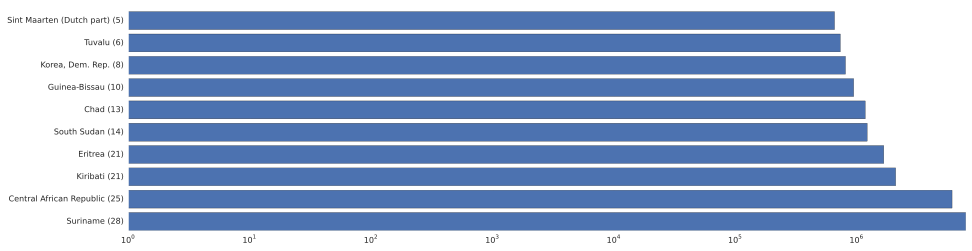

In [217]:
counts.sort(columns='counts',inplace=True)

topN=len(counts)
topN=10
direction=-1
direction=1

if not topN==counts.shape[0]:
    setFigSize(dim=(15,4))
else:
    setFigSize(dim=(15,35))

barList=plt.barh(range(topN),counts['counts'].values[::-1*direction][0:topN][::direction],0.8,log=True)
trash=plt.yticks([r+0.4 for r in range(topN)],[c+' ('+replaceThousands(countsHash[c])+')' for nn,c in enumerate(counts.index[::direction][0:topN][::-1*direction])])

if topN==counts.shape[0]:

    for n,bar in enumerate(barList):
        bar.set_color(colourHash[levelHash[counts.index[::direction][n][::-1*direction]]])
#        print counts.index[n],popHash[counts.index[n]]
    #    print counts.index[::-1][n],levelHash[counts.index[::-1][n]]
    #sys.exit(1)
    for n,(k,v) in enumerate(colourHash.items()):
    #    print k,v
        plt.annotate(k,xy=(0.05,0.91-(n*0.013)),xycoords='figure fraction',fontsize=24,color=v)

plt.xlim(1,7842000)

        
if not topN==counts.shape[0]:
    plt.savefig('../charts/as_count_'+str(topN)+'.png',dpi=200)
    print '../charts/as_count_'+str(topN)+'.png'
else:
    plt.xticks([],[])
    plt.tight_layout()
    plt.savefig('../charts/as_count.png',dpi=200)   

###Plot AS Per Capita

In [146]:
counts=counts[~(pd.isnull(counts.countsPerCapita))]
# Clean out Taiwan, no population

In [ ]:
counts.sort(columns='countsPerCapita',inplace=True)

../charts/as_per_capita_count_10.png


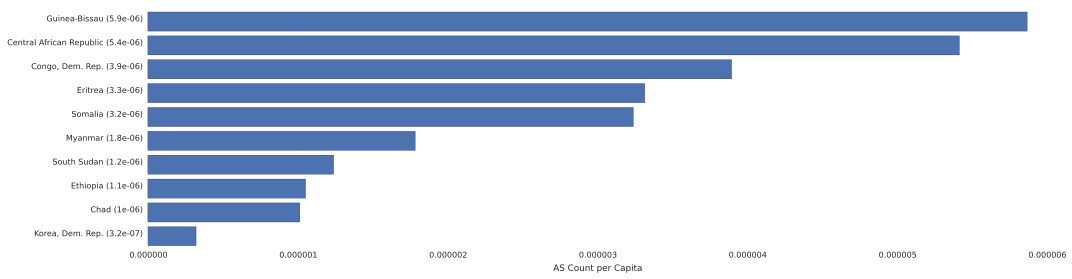

In [212]:
topN=counts.shape[0]
direction=-1

topN=10

if not topN==counts.shape[0]:
    setFigSize(dim=(15,4))
    isLog=False
else:
    setFigSize(dim=(15,35))
    isLog=True

barList=plt.barh(range(topN),counts.countsPerCapita.values[::-direction][0:topN][::-1*direction]\
                 ,0.8,log=isLog)
trash=plt.yticks([r+0.5 for r in range(topN)],[c+' (%.2g)' % \
            (counts['countsPerCapita'].values[::-1*direction][0:topN][::-1*direction][n]) \
            for n,c in enumerate(counts.index[::-1*direction][0:topN][::-1*direction])])
# +' ('+replaceThousands(countsHash[c])+')'
for n,bar in enumerate(barList):
#    print n, counts.index.values[::-1][n]
    row=counts.irow(n)
#    print row
#    print levelHash[finalDf.index.values[::-1][n]]

if topN==len(counts):

    for n,bar in enumerate(barList[::-1]):
        try:
            '''
            print counts.index[::direction][n]
            print levelHash[counts.index[::direction][n]]
            print colourHash[levelHash[counts.index[::direction][n]]]
            print '-----'
            '''
            bar.set_color(colourHash[levelHash[counts.index[::direction][n]]])
        except:
            print 'ERROR'
#        print counts.index[n],popHash[counts.index[n]]
    #    print counts.index[::-1][n],levelHash[counts.index[::-1][n]]
    #sys.exit(1)
    for n,k in enumerate(['High income','Upper middle income','Lower middle income','Low income']):
    #    print k,v
        plt.annotate(k,xy=(0.05,0.91-(n*0.013)),xycoords='figure fraction',fontsize=24,color=colourHash[k])

plt.xlabel('AS Count per Capita')
plt.tight_layout()

if not topN==len(counts):
    plt.savefig('../charts/as_per_capita_count_'+str(topN)+'.png',dpi=200)
    print '../charts/as_per_capita_count_'+str(topN)+'.png'
else:
    
    plt.savefig('../charts/as_per_capita_count.png',dpi=200)

###Now look at edges between countries

In [218]:
edgeFile=csv.reader(open('../data/midar-iff.links'),delimiter=' ')

In [26]:
!sed -n 1530,1540p ../data/midar-iff.links

link L1:  N8888118:1.0.0.1 N120707 N120708 
link L2:  N8888119:1.0.0.2 N120709 N120710 N106378 N120711 N120712 
link L3:  N8888120:1.0.0.6 N106378 N120711 
link L4:  N8888121:1.0.0.13 N120713 
link L5:  N8888122:1.0.0.164 N120714 
link L6:  N8888123:1.0.4.10 N120715 
link L7:  N8888124:1.0.8.250 N120716 N120717 
link L8:  N8888125:1.0.20.46 N120718 
link L9:  N120718:1.0.24.22 N120719 
link L10:  N8888126:1.0.24.150 N120720 
link L11:  N699985:1.1.0.1 N120721 N120722 


In [223]:
%%time
nodeGeoHash=collections.OrderedDict()
# Node #X=>country Y

for r in df.iterrows():
#    print r[1][1],r[1][2]
    nodeGeoHash[r[1][2]]=r[1][1]
#    sys.exit(1)

CPU times: user 56min 24s, sys: 22.7 s, total: 56min 46s
Wall time: 56min 12s


In [224]:
edgeCounter=collections.Counter()
ipCounter=collections.Counter()

#nodeGeoHash={}
# Figure out how to populate this later

for line in edgeFile:
    if not re.search(r'#',line[0]):
#        print line
        source=line[3].partition(':')[0]
#        print source
#        print nodeGeoHash.get(source)
#        print line[4:-1]
        
        for dest in line[4:-1]:
            edgeCounter[(nodeGeoHash.get(source),nodeGeoHash.get(dest))]+=1

        ipCounter[source]+=1
        # Count number of IPs associated with each AS
        
#        sys.exit(1)

In [225]:
for k,v in edgeCounter.most_common():
    if not k[0]==k[1] and k[0] and k[1]:
        print k,v

In [28]:
!head ../data/midar-iff.links

# version: $Id: kapar.cc,v 1.162 2012/03/14 00:24:54 kkeys Exp $
# version: $Id: PathLoader.cc,v 1.19 2012/01/04 20:44:46 kkeys Exp $
# start time: 1367051656 (2013-04-27 01:34:16 PDT)
# command line: /home/kkeys/WIP/topology/archipelago/aliasResolution/midar/../kapar/kapar -il -py -r31 -sir -c0.5 -nv -adms -d1 -mn -lb -1a -oals -O /scratch/alias-resolution/run-20130422/kapar/midar-iff -z 24
#   -B /scratch/alias-resolution/run-20130422/bogon-bn-agg-20130422.txt
#   -A /scratch/alias-resolution/run-20130422/kapar/midar-iff.pairs
#   -P /san5/topology/ark/data/team-probing/list-7.allpref24/team-1/daily/2013/cycle-20130407/daily.l7.t1.c002462.20130407.ams3-nl.warts.gz
#   -P /san5/topology/ark/data/team-probing/list-7.allpref24/team-1/daily/2013/cycle-20130407/daily.l7.t1.c002462.20130407.amw-us.warts.gz
#   -P /san5/topology/ark/data/team-probing/list-7.allpref24/team-1/daily/2013/cycle-20130407/daily.l7.t1.c002462.20130407.bcn-es.warts.gz
#   -P /san5/topology/ark/data/team-probing/lis

In [221]:
nodesDf=pd.read_csv('../data/midar-iff.nodes_count',delimiter='  ',header=False,names=['id','n'])

In [226]:
nodesDf.head()

,id,n
0,N2,697
1,N3,681
2,N4,630
3,N5,548
4,N6,359


In [228]:
nodesDf['country']=nodesDf['id'].apply(lambda x:nodeGeoHash.get(x))

In [229]:
nodesDf.head()

,id,n,country
0,N2,697,None
1,N3,681,None
2,N4,630,None
3,N5,548,None
4,N6,359,None


In [78]:
groups=nodesDf.groupby('country')

In [84]:
aggregated=groups.agg(np.sum)

In [86]:
aggregated.head()

,n
country,
A1,11397
A2,9724
AD,1026
AE,32211
AF,3220


In [88]:
aggregated.sort('n',ascending=False)

,n
country,
US,23600900
CN,18204066
KR,6239463
DE,4978297
BR,3633394
FR,3503206
JP,2819883
GB,2417173
ES,2182683
